# 2110443 - Computer Vision (2020/2)
## Lab 5 - Texture
In this lab, we will learn to use texture to segment 'things' from images. This notebook includes both coding and written questions. Please hand in this notebook file with all outputs and your answer. <br>
<b>Please note that collaboration is encouraged in this course.</b> You must turn in <b>your own write ups</b> of all problems. If you collaborate with others, you must put the names and ids of the students you worked with in below block.

Collaboration List:
- ...
- ...

<b>Remark : You need to install addition package name 'scikit-image' by using the following command line</b>

In [ ]:
!conda install scikit-image -c conda-forge -y

In [6]:
import numpy as np
import cv2
from skimage import io, color
from skimage.feature import local_binary_pattern, greycomatrix, greycoprops
from matplotlib import pyplot as plt

## Gray Level Co-Occurrence Matrix (GLCM)
A gray level co-occurrence Matrix is a matrix that is defined over an image to be the distribution of co-occurring pixel values at a given offset. It is used as an approach to texture analysis with various computer vision applications.

In [7]:
patternImage = np.array([
    [0, 0, 1, 1],
    [0, 0, 1, 1],
    [0, 2, 2, 2],
    [0, 2, 3, 3]], dtype=np.uint8)

#plt.imshow(patternImage, cmap='gray')
#plt.show()

We will use <a href="https://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=lbp#skimage.feature.greycomatrix">greycomatrix</a> function from scikit-image to extract GLCM from the sample pattern.

In [3]:
co_ocmatrix = greycomatrix(patternImage, distances=[1], angles=[0, np.pi/4, np.pi/2], levels=4)

print('angle 0')
print(co_ocmatrix[:,:,0,0])

print('angle 45')
print(co_ocmatrix[:,:,0,1])

print('angle 90')
print(co_ocmatrix[:,:,0,2])

angle 0
[[2 2 2 0]
 [0 2 0 0]
 [0 0 2 1]
 [0 0 0 1]]
angle 45
[[1 1 3 0]
 [0 1 1 0]
 [0 0 0 2]
 [0 0 0 0]]
angle 90
[[4 0 1 0]
 [0 2 2 0]
 [0 0 1 2]
 [0 0 0 0]]


### GLCM texture properties
Fron the  GLCM we can compute the following texture properties by using <a href=''>greycoprops</a> from scikit-image
- contrast $\sum_{i,j=0}^{levels-1} P_{i,j}(i-j)^2$
- dissimilarity $\sum_{i,j=0}^{levels-1}P_{i,j}|i-j|$
- homogeneity $\sum_{i,j=0}^{levels-1}\frac{P_{i,j}}{1+(i-j)^2}$
- correlation $\sum_{i,j=0}^{levels-1} P_{i,j}\left[\frac{(i-\mu_i)(j-\mu_j)}{\sqrt{(\sigma_i^2)(\sigma_j^2)}}\right]$

In [8]:
contrast = greycoprops(co_ocmatrix, prop='contrast')
dissimilarity = greycoprops(co_ocmatrix, prop='dissimilarity')

print(contrast, dissimilarity)

[[0.91666667 1.77777778 0.66666667]] [[0.58333333 1.11111111 0.5       ]]


In [9]:
patternImage2 = np.zeros((4,4), dtype=np.uint8) ## all black image!
co_ocmatrix2 = greycomatrix(patternImage2, distances=[1], angles=[0, np.pi/4, np.pi/2])

contrast2 = greycoprops(co_ocmatrix2, prop='contrast')
dissimilarity2 = greycoprops(co_ocmatrix2, prop='dissimilarity')
homogeneity2 = greycoprops(co_ocmatrix2, prop='homogeneity')

print(contrast2, dissimilarity2, homogeneity2)

[[0. 0. 0.]] [[0. 0. 0.]] [[1. 1. 1.]]


### Co-Occurrence matrix patch matching on bridge defect problem

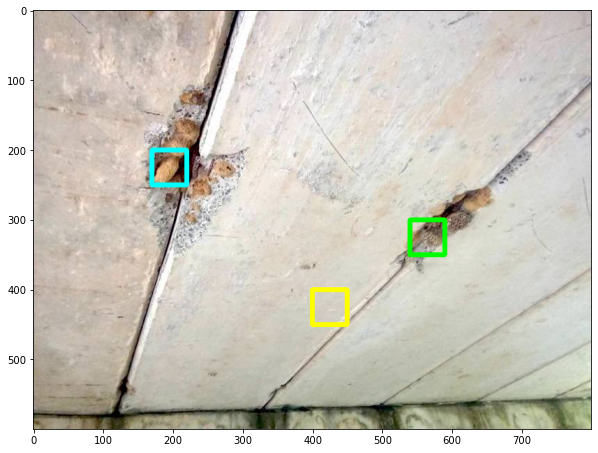

In [11]:
bridgeDefectImage = cv2.imread('assets/Lab5-crack.jpg')
dispImage = cv2.cvtColor(bridgeDefectImage.copy(), cv2.COLOR_BGR2RGB)

# Sample crack
cv2.rectangle(dispImage, (170,200), (220,250), (0,255,255), 5)

# Normal1
cv2.rectangle(dispImage, (400,400), (450,450), (255,255,0), 5)

# Crack2
cv2.rectangle(dispImage, (540,300), (590,350), (0,255,0), 5)


plt.figure(figsize=(10,10))
plt.imshow(dispImage, cmap='gray')

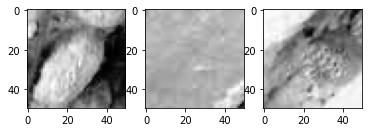

In [12]:
bridgeDefectImageGray = cv2.cvtColor(bridgeDefectImage, cv2.COLOR_BGR2GRAY)

crackPatch1 = bridgeDefectImageGray[200:250,170:220]

normalPatch1= bridgeDefectImageGray[400:450,400:450]

crackPatch2 = bridgeDefectImageGray[300:350,540:590]

_, axarr = plt.subplots(1,3)
axarr[0].imshow(crackPatch1, cmap='gray')
axarr[1].imshow(normalPatch1, cmap='gray')
axarr[2].imshow(crackPatch2, cmap='gray')

In [13]:
co_ocmatrix_crackpatch1 = greycomatrix(crackPatch1, distances=[1], angles=[0, np.pi/4, np.pi/2], symmetric=True, normed=True)

co_ocmatrix_normalpatch1 = greycomatrix(normalPatch1, distances=[1], angles=[0, np.pi/4, np.pi/2], symmetric=True, normed=True)

co_ocmatrix_crackpatch2 = greycomatrix(crackPatch2, distances=[1], angles=[0, np.pi/4, np.pi/2], symmetric=True, normed=True)

In [14]:
dist_normal_normal = np.linalg.norm(co_ocmatrix_crackpatch1-co_ocmatrix_crackpatch2)
print('distance crack-crack', dist_normal_normal)

dist_normal_crack = np.linalg.norm(co_ocmatrix_crackpatch1-co_ocmatrix_normalpatch1)
print('distance normal-crack', dist_normal_crack)

distance crack-crack 0.04674161444090442
distance normal-crack 0.18849734316785605


## Local Binary Pattern (LBP)
Local Binary Pattern (LBP) is a efficient texture operator which labels the pixels of an image by thresholding the neighborhood of each pixel and considers the result as a binary number.  It can be seen as a unifying approach to the traditionally divergent statistical and structural models of texture analysis. The most important property of the LBP operator in real-world applications is its robustness to monotonic gray-scale changes caused, for example, by illumination variations. Another important property is its computational simplicity, which makes it possible to analyze images in challenging real-time settings.

In [18]:
patternImage = np.array([
    [0, 0, 1, 1],
    [0, 0, 1, 1],
    [0, 2, 2, 2],
    [0, 2, 3, 3]], dtype=np.uint8)

#plt.imshow(patternImage, cmap='gray')
#plt.show()

In [16]:
lbpfeature = local_binary_pattern(patternImage, 8, 1)

Calculate LBP pattern for each patch by using scikit-image <a href="https://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=lbp#skimage.feature.local_binary_pattern">local_binary_pattern</a> <br>
<img src="assets/Lab5-LBP.jpg"/><br> Three neighborhood examples with varying p and r used to construct Local Binary Patterns. (Image from <a href="https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/">pyimagesearch</a>)

[[255. 255. 193. 112.]
 [255. 255. 231. 124.]
 [255. 193. 241. 112.]
 [255.   7.   1.  16.]]


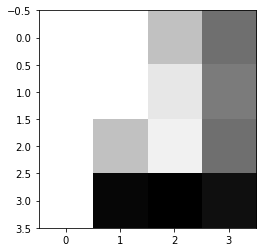

In [17]:
plt.imshow(lbpfeature, cmap='gray')
print(lbpfeature)

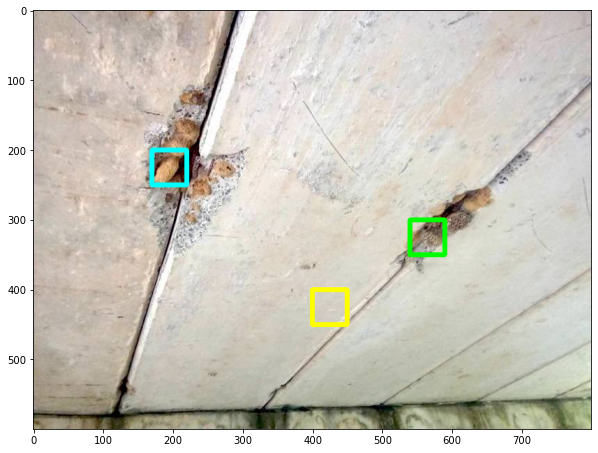

In [19]:
bridgeDefectImage = cv2.imread('assets/Lab5-crack.jpg')
dispImage = cv2.cvtColor(bridgeDefectImage.copy(), cv2.COLOR_BGR2RGB)

# Sample crack
cv2.rectangle(dispImage, (170,200), (220,250), (0,255,255), 5)

# Normal1
cv2.rectangle(dispImage, (400,400), (450,450), (255,255,0), 5)

# Crack2
cv2.rectangle(dispImage, (540,300), (590,350), (0,255,0), 5)


plt.figure(figsize=(10,10))
plt.imshow(dispImage, cmap='gray')

In [20]:
lbp_crackpatch1 =  local_binary_pattern(crackPatch1, P=16, R=8, method='uniform') 
lbp_normalpatch1 =  local_binary_pattern(normalPatch1, P=16, R=8, method='uniform')
lbp_crackpatch2 =  local_binary_pattern(crackPatch2, P=16, R=8, method='uniform') 

### LBP histogram

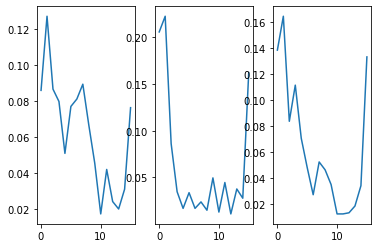

In [21]:
nBin = 16

_, axarr = plt.subplots(1,3)

hist_crackpatch1, _ = np.histogram(lbp_crackpatch1, density=True, bins=nBin, range=(0, nBin))
axarr[0].plot(hist_crackpatch1)

hist_normalpatch1, _ = np.histogram(lbp_normalpatch1, density=True, bins=nBin, range=(0, nBin))
axarr[1].plot(hist_normalpatch1)
    
hist_crackpatch2, _ = np.histogram(lbp_crackpatch2, density=True, bins=nBin, range=(0, nBin))
axarr[2].plot(hist_crackpatch2)

plt.show()

### LBP Histogram matching

#### Simple euclidean distance

In [22]:
print('Eucliden distance between crack-crack',np.linalg.norm(hist_crackpatch1 - hist_crackpatch2))
print('Eucliden distance between crack-normal',np.linalg.norm(hist_crackpatch1 - hist_normalpatch1))

Eucliden distance between crack-crack 0.12467372580672155
Eucliden distance between crack-normal 0.21812288712579597


#### KL divergence is a way of measuring the matching between two distributions 
(More detail can  be read from <a href="https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-understanding-kl-divergence-2b382ca2b2a8">here</a>)

In [23]:
def kldivergence(p, q):
    filt = np.logical_and(p != 0, q != 0)
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))

print('KL-Divergence between crack-crack', kldivergence(hist_crackpatch1 , hist_crackpatch2))
print('KL-Divergence between crack-normal', kldivergence(hist_crackpatch1 , hist_normalpatch1))

KL-Divergence between crack-crack 0.17946795689683298
KL-Divergence between crack-normal 0.4875303810015805


## Assignment 1 - Texture Segmentation

From the above section, we can magically matching each texture with sample patches. Your today task is to implement a program to segment this leopard from the background by using chosen texture feature and sliding window method. You can search and use any knowledge from internet but do not forget to proper credit your sources. <br>
<img src="assets/Lab5-leopard.jpg"/>

In [ ]:
leopardImage = cv2.imread('assets/Lab5-leopard.jpg', cv2.IMREAD_GRAYSCALE)
leopardImage = cv2.resize(leopardImage, None,fx=0.5,fy=0.5) #resize to reduce computation time

# Just sample patches, you can change to any position you want
leopardPatch1 = leopardImage[100:150,400:450]
leopardPatch2 = leopardImage[100:150,150:200]
leopardPatch3 = leopardImage[200:250,300:350]

nonleopardPatch1 = leopardImage[0:50,400:450]
nonleopardPatch2 = leopardImage[250:300,0:50]
nonleopardPatch3 = leopardImage[250:300,100:150]


plt.figure()
plt.imshow(leopardImage, cmap='gray')

plt.figure()
_, axarr = plt.subplots(1,3)
axarr[0].imshow(leopardPatch1, cmap='gray')
axarr[1].imshow(leopardPatch2, cmap='gray')
axarr[2].imshow(leopardPatch3, cmap='gray')

plt.figure()
_, axarr = plt.subplots(1,3)
axarr[0].imshow(nonleopardPatch1, cmap='gray')
axarr[1].imshow(nonleopardPatch2, cmap='gray')
axarr[2].imshow(nonleopardPatch3, cmap='gray')